# Task-2

# Q_1 Image

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Retina display
%config InlineBackend.figure_format = 'retina'
try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

unnamed (1).jpg exists
torch.Size([3, 800, 1280])


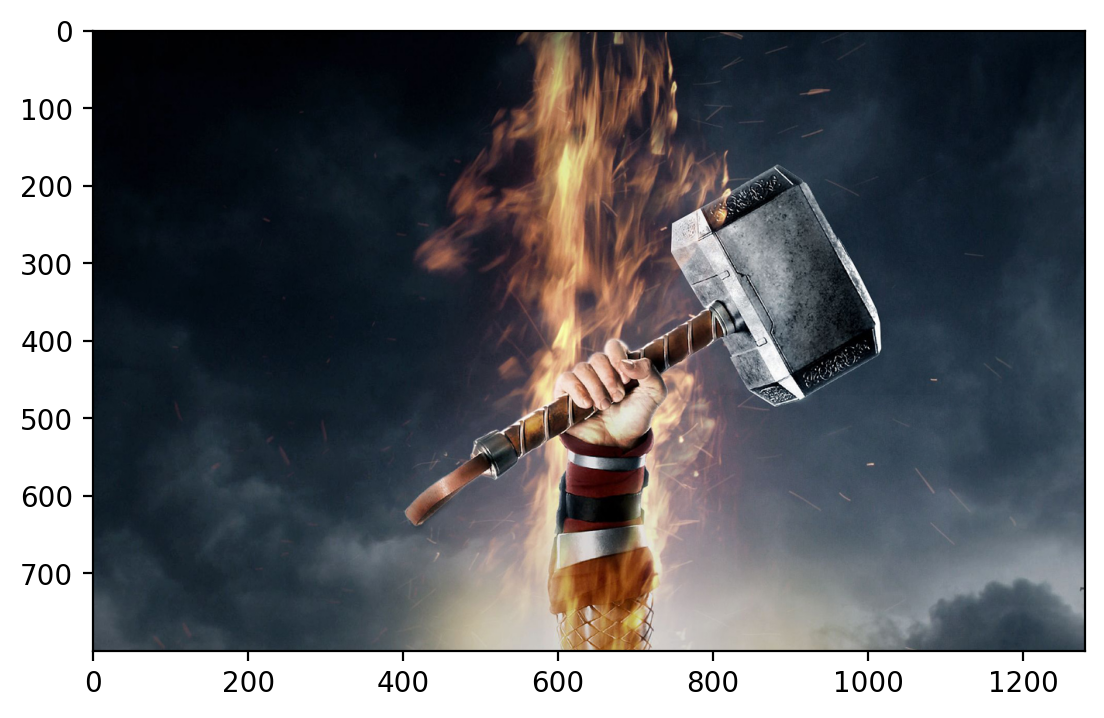

In [2]:
import os
import torchvision
image_path = r'unnamed (1).jpg'
if os.path.exists(image_path):
    print('unnamed (1).jpg exists')
    # Read in the image using torchvision
    img = torchvision.io.read_image(image_path)
    print(img.shape)
else:
    print('File does not exist')
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [3]:
from sklearn import preprocessing
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [4]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.0471, 0.0471, 0.0471],
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0118, 0.0118],
         ...,
         [0.2471, 0.2510, 0.2471,  ..., 0.2510, 0.2549, 0.2627],
         [0.2431, 0.2510, 0.2471,  ..., 0.2392, 0.2431, 0.2471],
         [0.2431, 0.2471, 0.2471,  ..., 0.2392, 0.2431, 0.2471]],

        [[0.0471, 0.0471, 0.0471,  ..., 0.0863, 0.0863, 0.0863],
         [0.0039, 0.0039, 0.0039,  ..., 0.0471, 0.0471, 0.0471],
         [0.0039, 0.0039, 0.0039,  ..., 0.0510, 0.0510, 0.0510],
         ...,
         [0.2863, 0.2902, 0.2863,  ..., 0.2980, 0.3020, 0.3098],
         [0.2824, 0.2902, 0.2863,  ..., 0.2863, 0.2902, 0.2941],
         [0.2824, 0.2863, 0.2863,  ..., 0.2863, 0.2902, 0.2941]],

        [[0.0549, 0.0549, 0.0549,  ..., 0.1216, 0.1216, 0.1216],
         [0.0118, 0.0118, 0.0118,  ..., 0.0824, 0.0824, 0.0824],
         [0.0118, 0.0118, 0.0118,  ..., 0.0902, 0.0902, 0.

torch.Size([3, 300, 300])


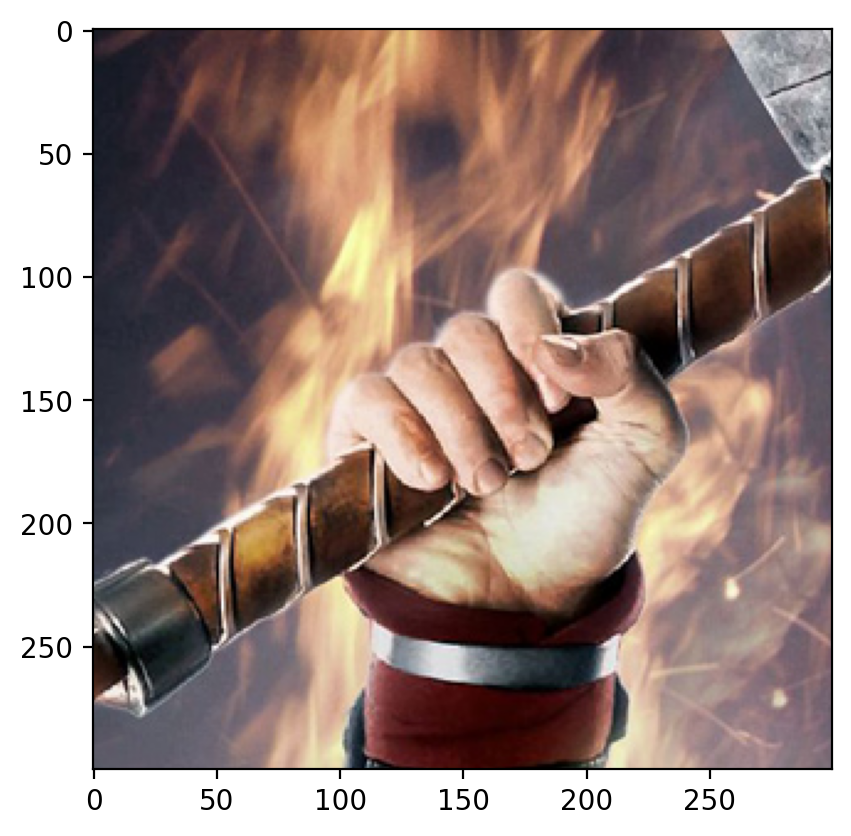

In [5]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 300, 500, 300, 300)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [6]:
crop = crop.to(device)
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 300 300


In [7]:
num_channels, height, width = 2, 3, 4
# Create a 2D grid of (x,y) coordinates
w_coords = torch.arange(width).repeat(height, 1)
h_coords = torch.arange(height).repeat(width, 1).t()
w_coords = w_coords.reshape(-1)
h_coords = h_coords.reshape(-1)
# Combine the x and y coordinates into a single tensor
X = torch.stack([h_coords, w_coords], dim=1).float()
X.shape

torch.Size([12, 2])

In [8]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    num_channels, height, width = img.shape
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)
    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()
    # Move X to GPU if available
    X = X.to(device)
    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y
unnamed_X, unnamed_Y = create_coordinate_map(crop)
unnamed_X.shape, unnamed_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [9]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(unnamed_X.cpu())
# Scale the X coordinates
unnamed_X_scaled = scaler_X.transform(unnamed_X.cpu())
# Move the scaled X coordinates to the GPU
unnamed_X_scaled = torch.tensor(unnamed_X_scaled).to(device)
# Set to dtype float32
unnamed_X_scaled = unnamed_X_scaled.float()

In [10]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
    def forward(self, x):
        return self.linear(x) 
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [11]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [12]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    for a in [ax0, ax1]:
        a.axis("off")
    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [15]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)
X_rff = create_rff_features(unnamed_X_scaled, 20000, 0.008)

In [16]:
print(X_rff.shape)
net = LinearModel(X_rff.shape[1], 3)
net.to(device)
train(net, 0.005, X_rff, unnamed_Y, 2500)

torch.Size([90000, 20000])
Epoch 0 loss: 0.249520
Epoch 100 loss: 0.033464
Epoch 200 loss: 0.018721
Epoch 300 loss: 0.013667
Epoch 400 loss: 0.010355
Epoch 500 loss: 0.008009
Epoch 600 loss: 0.006302
Epoch 700 loss: 0.005043
Epoch 800 loss: 0.004106
Epoch 900 loss: 0.003403
Epoch 1000 loss: 0.002874
Epoch 1100 loss: 0.002473
Epoch 1200 loss: 0.002169
Epoch 1300 loss: 0.001939
Epoch 1400 loss: 0.001765
Epoch 1500 loss: 0.001634
Epoch 1600 loss: 0.001536
Epoch 1700 loss: 0.001463
Epoch 1800 loss: 0.001410
Epoch 1900 loss: 0.001371
Epoch 2000 loss: 0.001342
Epoch 2100 loss: 0.001322
Epoch 2200 loss: 0.001307
Epoch 2300 loss: 0.001296
Epoch 2400 loss: 0.001289


0.0012828786857426167

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.060354996..1.0681684].


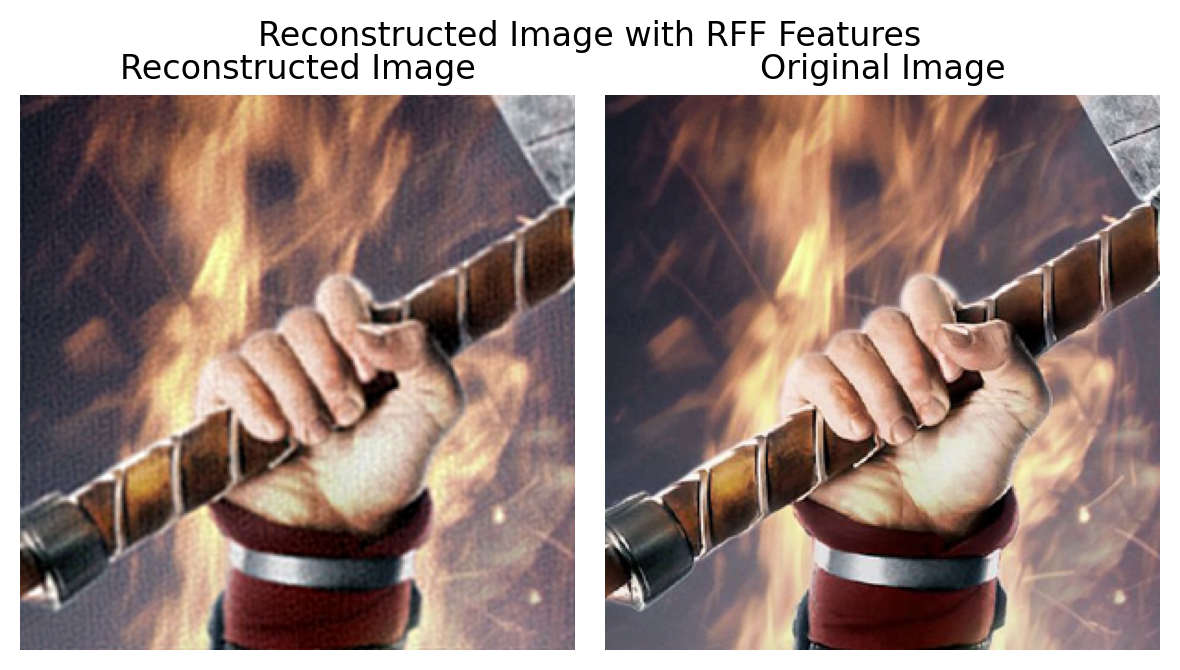

In [17]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [21]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
def calculate_rmse_psnr(original_img, reconstructed_img):
    """
    original_img: torch.Tensor of shape (num_channels, height, width)
    reconstructed_img: torch.Tensor of shape (num_channels, height, width)
    Returns: RMSE and PSNR
    """
    # Convert to numpy arrays and permute to shape (height, width, num_channels)
    original_img_np = original_img.cpu().numpy().transpose(1, 2, 0)
    reconstructed_img_np = reconstructed_img.cpu().numpy().transpose(1, 2, 0)
    # Flatten the images to 2D arrays (height*width, num_channels)
    original_img_np_flat = original_img_np.reshape(-1, original_img_np.shape[-1])
    reconstructed_img_np_flat = reconstructed_img_np.reshape(-1, reconstructed_img_np.shape[-1]) 
    # RMSE calculation
    rmse = math.sqrt(mean_squared_error(original_img_np_flat, reconstructed_img_np_flat))  
    # PSNR calculation
    psnr = 20 * math.log10(1.0 / rmse)  # Assuming the images are normalized to [0, 1]   
    return rmse, psnr
# Get the reconstructed image by passing X_rff through the trained network
with torch.no_grad():
    reconstructed_img = net(X_rff).reshape(crop.shape[1], crop.shape[2], crop.shape[0]).permute(2, 0, 1)
# Now calculate RMSE and PSNR between the original image (crop) and reconstructed image
rmse, psnr = calculate_rmse_psnr(crop, reconstructed_img)
print(f"RMSE: {rmse:.4f}, PSNR: {psnr:.2f} dB")


RMSE: 0.0358, PSNR: 28.92 dB
